# Spaceship Titanic Kaggle Competition

## Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## File and Data Field Descriptions
### `train.csv` 
Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### `test.csv` 
Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

### `sample_submission.csv` 
A submission file in the correct format.

`PassengerId` - Id for each passenger in the test set.

`Transported` - The target. For each passenger, predict either True or False.

### Imports

In [24]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Preprocessing 

In [25]:
# Define the CSV file path
train_file = 'train.csv' 
test_file = 'test.csv' 

# Read the CSV file into a pandas DataFrame
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

train_df['CryoSleep'] = train_df['CryoSleep'].astype(bool)
train_df['VIP'] = train_df['VIP'].astype(bool)

# Display the DataFrame
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Add a field called GroupId to the data. This is the first four characters of the PassengerId field.

In [26]:
train_df['GroupId'] = train_df['PassengerId'].str[:4].astype(int)

# Display the updated DataFrame
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4


Set CryoSleep to true if `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` are 0.

In [27]:
# Create a boolean condition to check if 'CryoSleep' is null and all specified columns are 0
condition = (train_df['CryoSleep'].isnull()) & (train_df['RoomService'] == 0) & (train_df['FoodCourt'] == 0) & (train_df['ShoppingMall'] == 0) & (train_df['Spa'] == 0) & (train_df['VRDeck'] == 0)

# Set 'CryoSleep' to True where the condition is True
train_df.loc[condition, 'CryoSleep'] = True

# Create a boolean condition to check if any of the specified columns are greater than 0
condition = (train_df['RoomService'] > 0) | (train_df['FoodCourt'] > 0) | (train_df['ShoppingMall'] > 0) | (train_df['Spa'] > 0) | (train_df['VRDeck'] > 0)

# Set 'CryoSleep' to False where the condition is True
train_df.loc[condition, 'CryoSleep'] = False


# Display the updated DataFrame
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4


If `Cabin` field is missing, copy it from a row with same `GroupId`

In [28]:
# Define a function to copy 'Cabin' from another row with the same 'GroupId'
def copy_cabin(row):
    if pd.isna(row['Cabin']):
        same_group = train_df[train_df['GroupId'] == row['GroupId']]
        if not same_group.empty:
            return same_group.iloc[0]['Cabin']
    return row['Cabin']

# Apply the function to fill missing 'Cabin' values
train_df['Cabin'] = train_df.apply(copy_cabin, axis=1)

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4


Split field `Cabin` into `CabinDeck`, `CabinNum` and `CabinSide`.

In [29]:
# Split the 'Cabin' column into three new columns: 'CabinDeck', 'CabinNum', and 'CabinSide'
train_df[['CabinDeck', 'CabinNum', 'CabinSide']] = train_df['Cabin'].str.extract('([A-Za-z]+)/(\d+)/([A-Za-z]+)')

# Display the updated DataFrame
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1,S


Remove fields `HomePlanet`, `Destination`, `Cabin`, `Name`

In [30]:
# List of columns to remove
columns_to_remove = ['HomePlanet', 'Destination', 'Cabin', 'Name']

# Drop the specified columns from the DataFrame
train_df = train_df.drop(columns=columns_to_remove)

# Display the updated DataFrame
train_df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,CabinDeck,CabinNum,CabinSide
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,F,0,S
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,A,0,S
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,A,0,S
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,F,1,S


If CryoSleep is true set `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` to be 0.
If CryoSleep is false set `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` to be the mean of the non-zero values.

In [31]:
# Set the specified columns to 0 where 'CryoSleep' is true
train_df.loc[train_df['CryoSleep'], ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0

# Calculate the means of the columns
mean_room_service = int(train_df[train_df['CryoSleep'] == False]['RoomService'].mean())
mean_food_court = int(train_df[train_df['CryoSleep'] == False]['FoodCourt'].mean())
mean_shopping_mall = int(train_df[train_df['CryoSleep'] == False]['ShoppingMall'].mean())
mean_spa = int(train_df[train_df['CryoSleep'] == False]['Spa'].mean())
mean_vr_deck = int(train_df[train_df['CryoSleep'] == False]['VRDeck'].mean())

# Fill missing values with the calculated means
train_df['RoomService'].fillna(mean_room_service, inplace=True)
train_df['FoodCourt'].fillna(mean_food_court, inplace=True)
train_df['ShoppingMall'].fillna(mean_shopping_mall, inplace=True)
train_df['Spa'].fillna(mean_spa, inplace=True)
train_df['VRDeck'].fillna(mean_vr_deck, inplace=True)

# Display the updated DataFrame
train_df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,CabinDeck,CabinNum,CabinSide
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,F,0,S
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,A,0,S
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,A,0,S
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,F,1,S


Replace missing age with mean age

In [32]:
mean_age = train_df['Age'].mean()

# Fill missing value with the calculated mean
train_df['Age'].fillna(mean_age, inplace=True)
train_df['Age'] = train_df['Age'].astype(int)

# Display the updated DataFrame
train_df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,CabinDeck,CabinNum,CabinSide
0,0001_01,False,39,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,0002_01,False,24,False,109.0,9.0,25.0,549.0,44.0,True,2,F,0,S
2,0003_01,False,58,True,43.0,3576.0,0.0,6715.0,49.0,False,3,A,0,S
3,0003_02,False,33,False,0.0,1283.0,371.0,3329.0,193.0,False,3,A,0,S
4,0004_01,False,16,False,303.0,70.0,151.0,565.0,2.0,True,4,F,1,S


Convert categorical data to Tensors using LabelEncoder and Numpy

In [33]:
cat_features=["CryoSleep", "VIP", "CabinDeck", "CabinNum", "CabinSide"]
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    train_df[feature]=lbl_encoders[feature].fit_transform(train_df[feature])

### Stacking the features
cat_values=np.stack([train_df[i].values for i in cat_features], 1)

### Convert numpy to Tensors
cat_values=torch.tensor(cat_values,dtype=torch.int64)
cat_values

tensor([[   0,    0,    1,    0,    0],
        [   0,    0,    5,    0,    1],
        [   0,    1,    0,    0,    1],
        ...,
        [   0,    0,    6,  551,    1],
        [   0,    0,    4, 1385,    1],
        [   0,    0,    4, 1385,    1]])

Convert Continous data to Tensors using Numpy

In [34]:
cont_features=["GroupId", "Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

### Stacking continuous variable to a tensor
cont_values=np.stack([train_df[i].values for i in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float)
cont_values

tensor([[1.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+00, 2.4000e+01, 1.0900e+02,  ..., 2.5000e+01, 5.4900e+02,
         4.4000e+01],
        [3.0000e+00, 5.8000e+01, 4.3000e+01,  ..., 0.0000e+00, 6.7150e+03,
         4.9000e+01],
        ...,
        [9.2790e+03, 2.6000e+01, 0.0000e+00,  ..., 1.8720e+03, 1.0000e+00,
         0.0000e+00],
        [9.2800e+03, 3.2000e+01, 0.0000e+00,  ..., 0.0000e+00, 3.5300e+02,
         3.2350e+03],
        [9.2800e+03, 4.4000e+01, 1.2600e+02,  ..., 0.0000e+00, 0.0000e+00,
         1.2000e+01]])

Extract the dependent feature `Transported` 

In [35]:
### Dependent Feature 
lbl_encoders={}
lbl_encoders["Transported"]=LabelEncoder()
train_df["Transported"]=lbl_encoders["Transported"].fit_transform(train_df["Transported"])

y=torch.tensor(train_df["Transported"].values,dtype=torch.float).reshape(-1,1)
y

tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]])

Check the sizes of feature tensors

In [36]:
cat_values.shape, cont_values.shape, y.shape

(torch.Size([8693, 5]), torch.Size([8693, 7]), torch.Size([8693, 1]))

Calculate embedding dimensions for Categorical Data

In [37]:
#### Embedding Size For Categorical columns
cat_dims=[len(train_df[col].unique()) for col in cat_features]
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]

embedding_dim

[(2, 1), (2, 1), (9, 5), (1818, 50), (3, 2)]

### Artificial Neural Network 

In [38]:
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.4):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

Check model

In [39]:
torch.manual_seed(100)
model=FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)
model

FeedForwardNN(
  (embeds): ModuleList(
    (0-1): 2 x Embedding(2, 1)
    (2): Embedding(9, 5)
    (3): Embedding(1818, 50)
    (4): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=66, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

Define loss function and optimizer

In [40]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

Split into test and train data

In [41]:
batch_size=8600
test_size=int(batch_size*0.2)
train_categorical=cat_values[:batch_size-test_size]
test_categorical=cat_values[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(6880, 1720, 6880, 1720, 6880, 1720)

Training the model

In [42]:
epochs=2000
final_losses=[]
for i in range(1, epochs + 1):
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss.detach())
    if i%10==0:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 10 and the loss : 0.5805906653404236
Epoch number: 20 and the loss : 0.4715309739112854


Epoch number: 30 and the loss : 0.4259904623031616
Epoch number: 40 and the loss : 0.40295514464378357
Epoch number: 50 and the loss : 0.3952273428440094
Epoch number: 60 and the loss : 0.38290712237358093
Epoch number: 70 and the loss : 0.37880468368530273
Epoch number: 80 and the loss : 0.366775244474411
Epoch number: 90 and the loss : 0.3601716458797455
Epoch number: 100 and the loss : 0.35103750228881836
Epoch number: 110 and the loss : 0.3449479639530182
Epoch number: 120 and the loss : 0.3371047079563141
Epoch number: 130 and the loss : 0.3302258849143982
Epoch number: 140 and the loss : 0.3219567537307739
Epoch number: 150 and the loss : 0.31418320536613464
Epoch number: 160 and the loss : 0.3076442778110504
Epoch number: 170 and the loss : 0.30581969022750854
Epoch number: 180 and the loss : 0.2938496470451355
Epoch number: 190 and the loss : 0.29085662961006165
Epoch number: 200 and the loss : 0.28385260701179504
Epoch number: 210 and the loss : 0.2821100354194641
Epoch number

Plot the training loss

Text(0.5, 0, 'epoch')

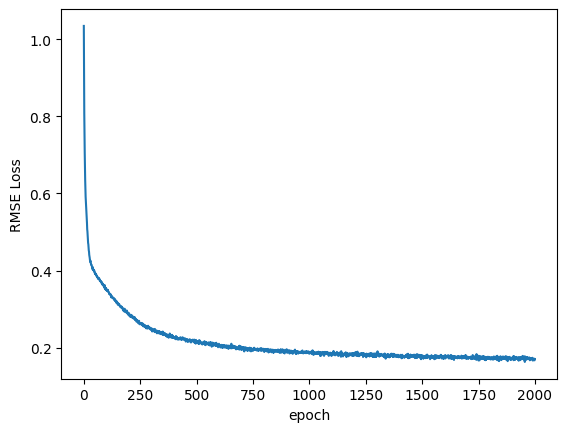

In [43]:
%matplotlib inline
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')



In [44]:
#### Validate the Test Data
y_pred=""
with torch.no_grad():
    y_pred=model(test_categorical,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))

RMSE: 0.4835728108882904


Save the model

In [45]:
torch.save(model,'model.pt')

Reload saved model

In [47]:
model1=torch.load('model.pt')
model1

FeedForwardNN(
  (embeds): ModuleList(
    (0-1): 2 x Embedding(2, 1)
    (2): Embedding(9, 5)
    (3): Embedding(1818, 50)
    (4): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=66, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)